# Kobe Bryant
By Jeremy Dumalig

Programming and Data Analytics

In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt
%pylab inline
from sklearn import linear_model
from sklearn import tree

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
kobe_data = pd.read_csv('https://raw.githubusercontent.com/jeremydumalig/Kobe-Bryant/master/kobe_data.csv')

## Modifying the Dataset
The following cells modify the dataset to replace strings with numerical values (easier to analyze).

For example, instead of "2PT Field Goal", it becomes 2.

In [5]:
#Create empty dictionaries
fg_dict = {"2PT Field Goal": 2, "3PT Field Goal": 3}
action_dict = {}
year_dict = {}
area_dict = {}
zone_dict = {}
matchup_dict = {}
opponent_dict = {}
combined_dict = {}
date_dict = {}

In [6]:
#Fill dictionaries with initial values and what to replace them with
for a in range (0, 57):
    action_dict[ kobe_data['action_type'].value_counts().index[a] ] = a

for b in range (1997, 2017):
    year_dict[ kobe_data.pivot_table(index=['season']).index[b - 1997] ] = b
    
for c in range (0, 6):
    area_dict[ kobe_data['shot_zone_area'].value_counts().index[c] ] = c
    
for d in range (0, 7):
    zone_dict[ kobe_data['shot_zone_basic'].value_counts().index[d] ] = d
    
for e in range (0, 74):
    matchup_dict[ kobe_data['matchup'].value_counts().index[e] ] = e

for f in range (0, 33):
    opponent_dict[ kobe_data['opponent'].value_counts().index[f] ] = f
    
for g in range (0, 6):
    combined_dict[ kobe_data['combined_shot_type'].value_counts().index[g] ] = g
    
for h in range (0, 1559):
    date_dict[ kobe_data['game_date'].value_counts().index[h] ] = h

In [7]:
#Actually replace the values in the dataset
factors = ['action_type', 'combined_shot_type', 'season', 'shot_type', 'shot_zone_area', 'shot_zone_basic', 'matchup', 'opponent', 'game_date']
diccionario = [action_dict, combined_dict, year_dict, fg_dict, area_dict, zone_dict, matchup_dict, opponent_dict, date_dict]

for j in range (0, 9):
    kobe_data[factors[j]] = kobe_data[factors[j]].map(diccionario[j])

## Clutch Factor

This section analyzes shots taken under 2 minutes in the 4th quarter or overtime periods.

In [8]:
#Switch opponents back to strings temporarily
reverse_opponent = {a: b for b, a in opponent_dict.items()}
kobe_data['opponent'] = kobe_data['opponent'].map(reverse_opponent)

#Create data frames of both misses and makes during crunch time, based on opponent
clutch_miss = kobe_data[ (kobe_data['minutes_remaining'] < 2) & (kobe_data['period'] > 3) & (kobe_data['shot_made_flag'] == 0) ]
opponent_miss = pd.DataFrame( clutch_miss['opponent'].value_counts() )
clutch_make = kobe_data[ (kobe_data['minutes_remaining'] < 2) & (kobe_data['period'] > 3) & (kobe_data['shot_made_flag'] == 1) ]
opponent_make = pd.DataFrame( clutch_make['opponent'].value_counts() )

#Join the data frames, sort data
clutch_percentage = opponent_miss.join(opponent_make, lsuffix='_miss', rsuffix='_make')
clutch_percentage['FGA'] = clutch_percentage['opponent_miss'] + clutch_percentage['opponent_make']
clutch_percentage['FG%'] = round(100*clutch_percentage['opponent_make'] / clutch_percentage['FGA'], 2)
del clutch_percentage['opponent_miss']
clutch_percentage = clutch_percentage.rename(columns={'opponent_make': 'FGM'})
clutch_percentage = clutch_percentage.sort_values(by='FG%', ascending=False)

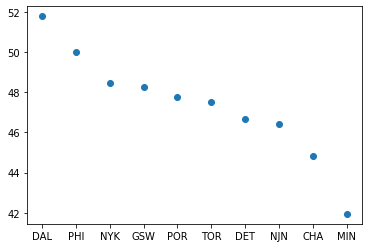

In [9]:
new = clutch_percentage.head(10)
plt.scatter(new.index, new['FG%'])

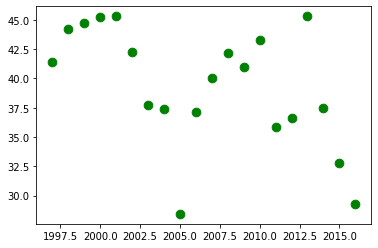

In [10]:
clutch = kobe_data[(kobe_data['minutes_remaining'] < 3) & (kobe_data['period'] > 3)].pivot_table(index=['season'])
clutch['shot_made_flag'] = clutch['shot_made_flag']*100
fig = matplotlib.pyplot.figure()
plt.xlim(1996, 2017)
plt.scatter(clutch.index, clutch['shot_made_flag'], color="green", s=75)

## Predictions for Null Values in Dataset

In the given dataset, whether or not Kobe made a field goal is stored as a binary (made shot = 1, missed shot = 0).

There are 5,000 empty values for which we are supposed to predict.

This prediction model takes into account 14 factors: action type, combined shot type, x-location, y-location, period, playoffs, season, shot distance, shot type, shot area, shot zone, game date, matchup, and opponent.

In [11]:
#Map all opponent values from strings to numerical values
kobe_data['opponent'] = kobe_data['opponent'].map(opponent_dict)

#Extend list of factors
appended_factors = ['loc_x', 'loc_y', 'period', 'playoffs', 'shot_distance']
for x in range (0, len(appended_factors)):
    factors.append(appended_factors[x])

In [12]:
#Create data frames of null values and known values, create list of all factors
non_data = kobe_data[ ~(kobe_data['shot_made_flag'] == 0) & ~(kobe_data['shot_made_flag'] == 1) ]
data = kobe_data[ (kobe_data['shot_made_flag'] == 0) | (kobe_data['shot_made_flag'] == 1) ]

#Establish X and Y values for known shots, create decision tree for predictions
X = data[factors]
Y = data['shot_made_flag']

p_model = tree.DecisionTreeClassifier()
p_model = p_model.fit(X, Y)

In [13]:
#Create empty lists
predictions = []
x_locations = []
y_locations = []
season = []
shot_type = []
game_id = []

#Make predictions for all 5,000 null values, append court location and prediction to above lists
for x in range (0, len(non_data)):
    inputs = []
    
    non_index = non_data.index[x]
    for y in range (0, len(factors)):
        inputs.append(non_data[ factors[y] ][non_index])
    
    prediction = p_model.predict([inputs])
    prediction = int(prediction[0])
    
    predictions.append(prediction)
    x_locations.append(non_data['loc_x'][non_index])
    y_locations.append(non_data['loc_y'][non_index])
    season.append(non_data['season'][non_index])
    shot_type.append(non_data['shot_type'][non_index])
    game_id.append(non_data['game_id'][non_index])

In [14]:
#Create data frame of all predicted shot attempts with x and y locations
DF_data = {'loc_x': x_locations, 'loc_y': y_locations, 'predictions': predictions, 'season': season, 'shot_type': shot_type, 'game_id': game_id}
generated_predictions = pd.DataFrame(data=DF_data)

In [15]:
#Define function that counts number of unique elements in a list (useful for pivot table's aggfunc)
def count(thing):
    result = np.unique(thing)
    return len(result)

generated_makes = generated_predictions[(generated_predictions['predictions'] == 1)].pivot_table(index=['season'], aggfunc=sum)[['shot_type']]
generated_makes['generated_makes'] = generated_makes['shot_type']

known_makes = kobe_data[(kobe_data['shot_made_flag'] == 1)].pivot_table(index=['season'], aggfunc=sum)[['shot_type']]
known_makes['known_makes'] = known_makes['shot_type']

game_count = kobe_data.pivot_table(index=['season'], aggfunc=count)[['game_id']]

all_predicted = generated_makes[['generated_makes']].join(known_makes[['known_makes']])
all_predicted['games_played'] = game_count['game_id']
all_predicted['ppg'] = (all_predicted['generated_makes'] + all_predicted['known_makes']) / all_predicted['games_played']

## Predicted PPG vs Actual PPG

In [16]:
kobe_actual = pd.read_csv('https://raw.githubusercontent.com/jeremydumalig/Kobe-Bryant/master/kobe.csv')
kobe_actual.index = kobe_actual['Season']
kobe_actual['PTS'] = kobe_actual['PTS'] - kobe_actual['FT']
kobe_actual = kobe_actual[['PTS']]

In [17]:
#Create range for regressions (through 2020)
season = []
for year in range(1996, 2021):
    season.append(year)
years = {'year': season}
seasons = pd.DataFrame(data=years)

#Define function that takes an input and returns the predicted value according to regression
def fg_regression(x):
    return (coeffs[0])*(x**2) + (coeffs[1])*(x) + (coeffs[2])

In [18]:
generated_makes = generated_predictions[(generated_predictions['predictions'] == 1)].pivot_table(index=['season'], aggfunc=sum)[['shot_type']]
generated_makes['generated_makes'] = generated_makes['shot_type']

known_makes = kobe_data[(kobe_data['shot_made_flag'] == 1)].pivot_table(index=['season'], aggfunc=sum)[['shot_type']]
known_makes['known_makes'] = known_makes['shot_type']

game_count = kobe_data.pivot_table(index=['season'], aggfunc=count)[['game_id']]

all_predicted = generated_makes[['generated_makes']].join(known_makes[['known_makes']])
all_predicted['games_played'] = game_count['game_id']
all_predicted['ppg'] = (all_predicted['generated_makes'] + all_predicted['known_makes']) / all_predicted['games_played']

Prediction for 2017 : 9.8 points
Prediction for 2018 : 7.1 points
Prediction for 2019 : 4.0 points
Prediction for 2020 : 0.7 points


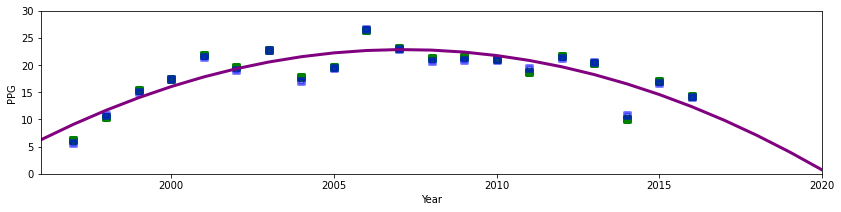

In [50]:
#Create figure
fig = matplotlib.pyplot.figure()
#fig.suptitle("Predicted")
matplotlib.pyplot.xlabel('Year')
matplotlib.pyplot.ylabel('PPG')
plt.xlim(1996, 2020)
plt.ylim(0, 30)
fig.set_figheight(3)
fig.set_figwidth(14)

#Print predictionsx = ppg.index
x = all_predicted.index
y = all_predicted['ppg']
z = np.polyfit(x, y, 2)
coeffs = []
for i in range (0, len(z)):
    coeffs.append(z[i])
    
#Plot actual values and curve of best fit
X = seasons['year']
Y = fg_regression(X)
    
matplotlib.pyplot.scatter(all_predicted.index, all_predicted['ppg'], color='green', marker="s", linewidths = 3)
matplotlib.pyplot.scatter(kobe_actual.index, kobe_actual['PTS'], color='blue', marker="s", linewidths = 3, alpha=0.5)
matplotlib.pyplot.plot(X, Y, color='purple', linewidth=3)
    
for a in range (2017, 2021):
    print("Prediction for", a, ":", round(fg_regression(a), 1), "points")

## Importing Data for Other Players

In [20]:
#Dwyane Wade Data
wade_data = pd.read_csv('https://raw.githubusercontent.com/jeremydumalig/Kobe-Bryant/master/wade.csv')
wade_data = wade_data[['Season', 'FG%', '3P%', '2P%', 'PTS', 'FT', '2PA', 'FGA']]

wade_data['FG%'] = wade_data['FG%']*100
wade_data['2P%'] = wade_data['2P%']*100
wade_data['3P%'] = wade_data['3P%']*100
wade_data['PPG'] = wade_data['PTS'] - wade_data['FT']
wade_data['2R'] = round(100*wade_data['2PA']/wade_data['FGA'], 1)
wade_data['Season'] = wade_data['Season'] - 7

#Michael Jordan Data
mj_data = pd.read_csv('https://raw.githubusercontent.com/jeremydumalig/Kobe-Bryant/master/mj.csv')
mj_data = mj_data[['Season', 'FG%', '3P%', '2P%', 'PTS', 'FT', '2PA', 'FGA']]

mj_data['FG%'] = mj_data['FG%']*100
mj_data['2P%'] = mj_data['2P%']*100
mj_data['3P%'] = mj_data['3P%']*100
mj_data['PPG'] = mj_data['PTS'] - mj_data['FT']
mj_data['2R'] = round(100*mj_data['2PA']/mj_data['FGA'], 1)
mj_data['Season'] = mj_data['Season']+12

#LeBron James Data
lebron_data = pd.read_csv('https://raw.githubusercontent.com/jeremydumalig/Kobe-Bryant/master/lebron.csv')
lebron_data = lebron_data[['Season', 'FG%', '3P%', '2P%', 'PTS', 'FT', '2PA', 'FGA']]

lebron_data['FG%'] = lebron_data['FG%']*100
lebron_data['2P%'] = lebron_data['2P%']*100
lebron_data['3P%'] = lebron_data['3P%']*100
lebron_data['PPG'] = lebron_data['PTS'] - lebron_data['FT']
lebron_data['2R'] = round(100*lebron_data['2PA']/lebron_data['FGA'], 1)
lebron_data['Season'] = lebron_data['Season'] - 7

## Linear and Quadratic Regression over Kobe's 20-Year Career

This section plots data sets from Kobe's career and predicts his production if he never retired.

In [21]:
#Create data frame of shot distance and FG percentage by season
seasonFG = pd.DataFrame(kobe_data.pivot_table(index=['season']))
seasonFG = seasonFG[ ['shot_made_flag', 'shot_distance'] ]
seasonFG['FG%'] = 100*seasonFG['shot_made_flag']
del seasonFG['shot_made_flag']

Prediction for 2017 : 33.3 %
Prediction for 2018 : 30.7 %
Prediction for 2019 : 28.0 %
Prediction for 2020 : 25.0 %


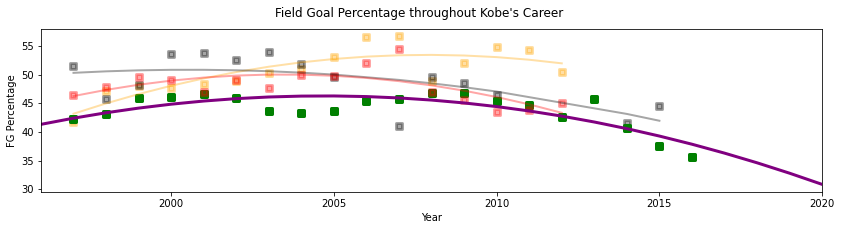

In [22]:
#Perform quadratic regression on FG%
x = seasonFG.index
y = seasonFG['FG%']
z = np.polyfit(x, y, 2)
coeffs = []
for i in range (0, len(z)):
    coeffs.append(z[i])

#Create figure
fig = matplotlib.pyplot.figure()
fig.suptitle("Field Goal Percentage throughout Kobe's Career")
matplotlib.pyplot.xlabel('Year')
matplotlib.pyplot.ylabel('FG Percentage')
plt.xlim(1996, 2020)
fig.set_figheight(3)
fig.set_figwidth(14)

#Plot actual values and curve of best fit
X = seasons['year']
Y = fg_regression(X)

a = lebron_data['Season']
b = lebron_data['FG%']
c = np.polyfit(a, b, 2)
coeffs = []
for i in range (0, len(c)):
    coeffs.append(c[i])
A = lebron_data['Season']
B = fg_regression(A)
matplotlib.pyplot.scatter(lebron_data['Season'], lebron_data['FG%'], color='orange', marker="s", linewidths = 3, alpha=0.35)
matplotlib.pyplot.plot(A, B, color='orange', linewidth=2, alpha=0.35)


a = mj_data['Season']
b = mj_data['FG%']
c = np.polyfit(a, b, 2)
coeffs = []
for i in range (0, len(c)):
    coeffs.append(c[i])
A = mj_data['Season']
B = fg_regression(A)
matplotlib.pyplot.scatter(mj_data['Season'], mj_data['FG%'], color='black', marker="s", linewidths = 3, alpha=0.35)
matplotlib.pyplot.plot(A, B, color='black', linewidth=2, alpha=0.35)

a = wade_data['Season']
b = wade_data['FG%']
c = np.polyfit(a, b, 2)
coeffs = []
for i in range (0, len(c)):
    coeffs.append(c[i])
A = wade_data['Season']
B = fg_regression(A)

matplotlib.pyplot.scatter(seasonFG.index, seasonFG['FG%'], color='green', marker="s", linewidths = 3)
matplotlib.pyplot.scatter(wade_data['Season'], wade_data['FG%'], color='red', marker="s", linewidths = 3, alpha=0.35)
matplotlib.pyplot.plot(X, Y, color='purple', linewidth=3)
matplotlib.pyplot.plot(A, B, color='red', linewidth=2, alpha=0.35)

#Print predictions
for a in range (2017, 2021):
    print("Prediction for", a, ":", round(fg_regression(a), 1), "%")

Prediction for 2017 : 15.7 feet
Prediction for 2018 : 15.9 feet
Prediction for 2019 : 16.1 feet
Prediction for 2020 : 16.3 feet


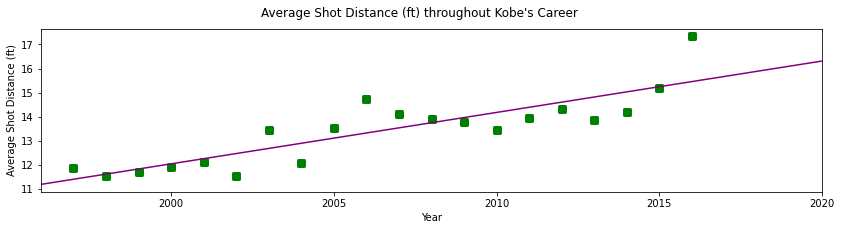

In [28]:
#Create linear model and perform regression
model = linear_model.LinearRegression()

index = seasonFG.index.values.reshape(-1, 1)
shot_distance = seasonFG['shot_distance'].values.reshape(-1, 1)

model.fit(X=index, y=shot_distance)

#Create figure
fig = matplotlib.pyplot.figure()
fig.suptitle("Average Shot Distance (ft) throughout Kobe's Career")
matplotlib.pyplot.xlabel('Year')
matplotlib.pyplot.ylabel('Average Shot Distance (ft)')
fig.set_figheight(3)
fig.set_figwidth(14)

#Plot actual values and line of best fit
X = seasons['year']
Y = model.predict(list(zip(X)))

matplotlib.pyplot.scatter(seasonFG.index, seasonFG['shot_distance'], color='green', marker="s", linewidths = 3)
matplotlib.pyplot.plot(X, Y, color="purple")
plt.xlim(1996, 2020)

#Print predictions
for a in range (2017, 2021):
    print("Prediction for", a, ":", round(model.predict([[a]])[0][0], 1), "feet")

In [29]:
#Create data frame of 2-PT FG percentage by season
new_kobe_data = kobe_data[(kobe_data['shot_type'] == 2)]
seasonFG2 = new_kobe_data.pivot_table(index=['season'])
seasonFG2 = pd.DataFrame(seasonFG2['shot_made_flag'])
seasonFG2['FG%'] = 100*seasonFG2['shot_made_flag']
del seasonFG2['shot_made_flag']

Prediction for 2017 : 33.5 %
Prediction for 2018 : 30.5 %
Prediction for 2019 : 27.4 %
Prediction for 2020 : 24.0 %


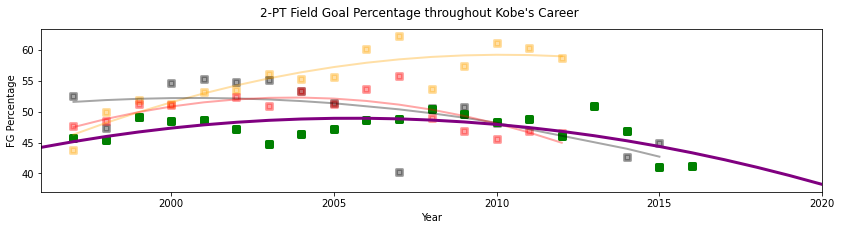

In [30]:
#Perform quadratic regression on FG%
x = seasonFG2.index
y = seasonFG2['FG%']
z = np.polyfit(x, y, 2)
coeffs = []
for i in range (0, len(z)):
    coeffs.append(z[i])

#Create figure
fig = matplotlib.pyplot.figure()
fig.suptitle("2-PT Field Goal Percentage throughout Kobe's Career")
matplotlib.pyplot.xlabel('Year')
matplotlib.pyplot.ylabel('FG Percentage')
plt.xlim(1996, 2020)
fig.set_figheight(3)
fig.set_figwidth(14)

#Plot actual values and curve of best fit
X = seasons['year']
Y = fg_regression(X)

a = lebron_data['Season']
b = lebron_data['2P%']
c = np.polyfit(a, b, 2)
coeffs = []
for i in range (0, len(c)):
    coeffs.append(c[i])
A = lebron_data['Season']
B = fg_regression(A)
matplotlib.pyplot.scatter(lebron_data['Season'], lebron_data['2P%'], color='orange', marker="s", linewidths = 3, alpha=0.35)
matplotlib.pyplot.plot(A, B, color='orange', linewidth=2, alpha=0.35)

a = mj_data['Season']
b = mj_data['2P%']
c = np.polyfit(a, b, 2)
coeffs = []
for i in range (0, len(c)):
    coeffs.append(c[i])
A = mj_data['Season']
B = fg_regression(A)
matplotlib.pyplot.scatter(mj_data['Season'], mj_data['2P%'], color='black', marker="s", linewidths = 3, alpha=0.35)
matplotlib.pyplot.plot(A, B, color='black', linewidth=2, alpha=0.35)

a = wade_data['Season']
b = wade_data['2P%']
c = np.polyfit(a, b, 2)
coeffs = []
for i in range (0, len(c)):
    coeffs.append(c[i])
A = wade_data['Season']
B = fg_regression(A)
matplotlib.pyplot.scatter(wade_data['Season'], wade_data['2P%'], color='red', marker="s", linewidths = 3, alpha=0.35)
matplotlib.pyplot.plot(A, B, color='red', linewidth=2, alpha=0.35)

matplotlib.pyplot.scatter(seasonFG2.index, seasonFG2['FG%'], color='green', marker="s", linewidths = 3)
matplotlib.pyplot.plot(X, Y, color='purple', linewidth=3)

#Print predictions
for a in range (2017, 2021):
    print("Prediction for", a, ":", round(fg_regression(a), 1), "%")

In [31]:
#Create data frame of 3-PT FG percentage by season
new_kobe_data = kobe_data[(kobe_data['shot_type'] == 3)]
seasonFG3 = new_kobe_data.pivot_table(index=['season'])
seasonFG3 = pd.DataFrame(seasonFG3['shot_made_flag'])
seasonFG3['FG%'] = 100*seasonFG3['shot_made_flag']
del seasonFG3['shot_made_flag']

Prediction for 2017 : 42.1 %
Prediction for 2018 : 44.4 %
Prediction for 2019 : 46.9 %
Prediction for 2020 : 49.5 %


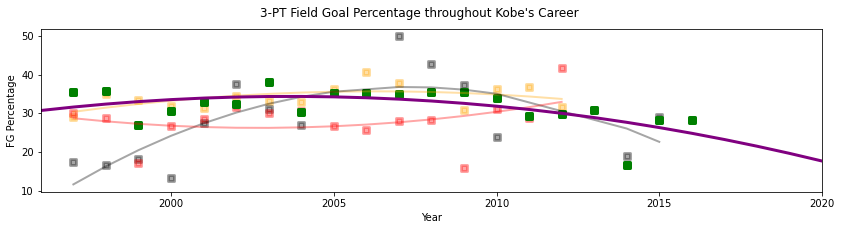

In [33]:
#Perform quadratic regression on FG%
x = seasonFG3.index
y = seasonFG3['FG%']
z = np.polyfit(x, y, 2)
coeffs = []
for i in range (0, len(z)):
    coeffs.append(z[i])

#Create figure
fig = matplotlib.pyplot.figure()
fig.suptitle("3-PT Field Goal Percentage throughout Kobe's Career")
matplotlib.pyplot.xlabel('Year')
matplotlib.pyplot.ylabel('FG Percentage')
plt.xlim(1996, 2020)
fig.set_figheight(3)
fig.set_figwidth(14)

#Plot actual values and curve of best fit
X = seasons['year']
Y = fg_regression(X)

a = lebron_data['Season']
b = lebron_data['3P%']
c = np.polyfit(a, b, 2)
coeffs = []
for i in range (0, len(c)):
    coeffs.append(c[i])
A = lebron_data['Season']
B = fg_regression(A)
matplotlib.pyplot.scatter(lebron_data['Season'], lebron_data['3P%'], color='orange', marker="s", linewidths = 3, alpha=0.35)
matplotlib.pyplot.plot(A, B, color='orange', linewidth=2, alpha=0.35)

a = mj_data['Season']
b = mj_data['3P%']
c = np.polyfit(a, b, 2)
coeffs = []
for i in range (0, len(c)):
    coeffs.append(c[i])
A = mj_data['Season']
B = fg_regression(A)
matplotlib.pyplot.scatter(mj_data['Season'], mj_data['3P%'], color='black', marker="s", linewidths = 3, alpha=0.35)
matplotlib.pyplot.plot(A, B, color='black', linewidth=2, alpha=0.35)

a = wade_data['Season']
b = wade_data['3P%']
c = np.polyfit(a, b, 2)
coeffs = []
for i in range (0, len(c)):
    coeffs.append(c[i])
A = wade_data['Season']
B = fg_regression(A)
matplotlib.pyplot.scatter(wade_data['Season'], wade_data['3P%'], color='red', marker="s", linewidths = 3, alpha=0.35)
matplotlib.pyplot.plot(A, B, color='red', linewidth=2, alpha=0.35)

matplotlib.pyplot.scatter(seasonFG.index, seasonFG3['FG%'], color='green', marker="s", linewidths = 3)
matplotlib.pyplot.plot(X, Y, color='purple', linewidth=3)

#Print predictions
for a in range (2017, 2021):
    print("Prediction for", a, ":", round(fg_regression(a), 1), "%")

In [34]:
#Create pivot table to find out how many games Kobe played in by season
games_id = kobe_data[ (kobe_data['shot_made_flag'] == 1)]
pivoted_games_id = games_id.pivot_table(index=['season'], aggfunc=count)
pivoted_games_id = pivoted_games_id[ ['game_id'] ]

#Find total points scored by season
fg_dict = {2: 2, 0: 3}

total_pts = kobe_data[ (kobe_data['shot_made_flag'] == 1)]
total_pts['points_made'] = total_pts['shot_type'].map(fg_dict)
pivoted_total_pts = total_pts.pivot_table(index=['season'], aggfunc=sum)
pivoted_total_pts = pivoted_total_pts[ ['points_made'] ]

#Create data frame of points per game by season
ppg = pivoted_total_pts.join(pivoted_games_id)
ppg['ppg'] = ppg['points_made'] / ppg['game_id']
del ppg['points_made']
del ppg['game_id']

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Prediction for 2017 : 9.8 points
Prediction for 2018 : 7.1 points
Prediction for 2019 : 4.0 points
Prediction for 2020 : 0.7 points


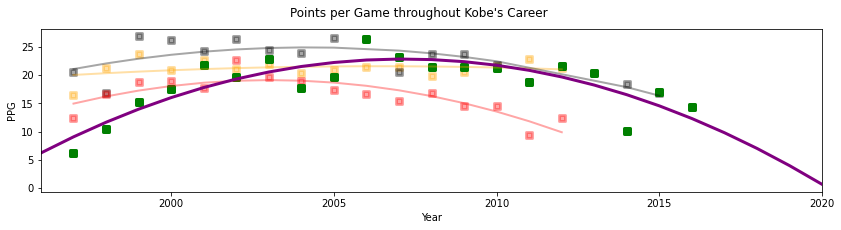

In [35]:
#Perform quadratic regression on FG%
x = all_predicted.index
y = all_predicted['ppg']
z = np.polyfit(x, y, 2)
coeffs = []
for i in range (0, len(z)):
    coeffs.append(z[i])

#Create figure
fig = matplotlib.pyplot.figure()
fig.suptitle("Points per Game throughout Kobe's Career")
matplotlib.pyplot.xlabel('Year')
matplotlib.pyplot.ylabel('PPG')
plt.xlim(1996, 2020)
fig.set_figheight(3)
fig.set_figwidth(14)

#Plot actual values and curve of best fit
X = seasons['year']
Y = fg_regression(X)

a = lebron_data['Season']
b = lebron_data['PPG']
c = np.polyfit(a, b, 2)
coeffs = []
for i in range (0, len(c)):
    coeffs.append(c[i])
A = lebron_data['Season']
B = fg_regression(A)
matplotlib.pyplot.scatter(lebron_data['Season'], lebron_data['PPG'], color='orange', marker="s", linewidths = 3, alpha=0.35)
matplotlib.pyplot.plot(A, B, color='orange', linewidth=2, alpha=0.35)

a = mj_data['Season']
b = mj_data['PPG']
c = np.polyfit(a, b, 2)
coeffs = []
for i in range (0, len(c)):
    coeffs.append(c[i])
A = mj_data['Season']
B = fg_regression(A)
matplotlib.pyplot.scatter(mj_data['Season'], mj_data['PPG'], color='black', marker="s", linewidths = 3, alpha=0.35)
matplotlib.pyplot.plot(A, B, color='black', linewidth=2, alpha=0.35)

a = wade_data['Season']
b = wade_data['PPG']
c = np.polyfit(a, b, 2)
coeffs = []
for i in range (0, len(c)):
    coeffs.append(c[i])
A = wade_data['Season']
B = fg_regression(A)
matplotlib.pyplot.scatter(wade_data['Season'], wade_data['PPG'], color='red', marker="s", linewidths = 3, alpha=0.35)
matplotlib.pyplot.plot(A, B, color='red', linewidth=2, alpha=0.35)

matplotlib.pyplot.scatter(all_predicted.index, all_predicted['ppg'], color='green', marker="s", linewidths = 3)
matplotlib.pyplot.plot(X, Y, color='purple', linewidth=3)

#Print predictionsx = ppg.index
x = all_predicted.index
y = all_predicted['ppg']
z = np.polyfit(x, y, 2)
coeffs = []
for i in range (0, len(z)):
    coeffs.append(z[i])
    
for a in range (2017, 2021):
    print("Prediction for", a, ":", round(fg_regression(a), 1), "points")

In [36]:
#Create data frame to find out total shots attempted by season
total_shots = kobe_data.pivot_table(index=['season'], aggfunc=count)
shot_id = pd.DataFrame(total_shots['shot_id'])

In [37]:
#Find max points scored off of 2-PT attempts, divide by 2 to find total 2-PT field goals attempted
fg_dict = {2: 2, 3: 0}

kobe_data['shot_total'] = kobe_data['shot_type'].map(fg_dict)

shots = kobe_data.pivot_table(index=['season'], aggfunc=sum)
shots['shot_total'] = shots['shot_total']/2

#Create data frame of total 2-PT and 3-PT field goals attempted, find percentages of total shots attempted
two_DF = pd.DataFrame(shots['shot_total'])
two_DF['2-PT FG'] = two_DF['shot_total']
two_DF['3-PT FG'] = shot_id['shot_id'] - two_DF['shot_total']
del two_DF['shot_total']
two_DF['% of Total Shots that were 2-PT FG'] = round(100*two_DF['2-PT FG'] / shot_id['shot_id'], 2)
two_DF['% of Total Shots that were 3-PT FG'] = round(100*two_DF['3-PT FG'] / shot_id['shot_id'], 2)

Prediction for 2017 : 63.4 %
Prediction for 2018 : 59.5 %
Prediction for 2019 : 55.5 %
Prediction for 2020 : 51.2 %


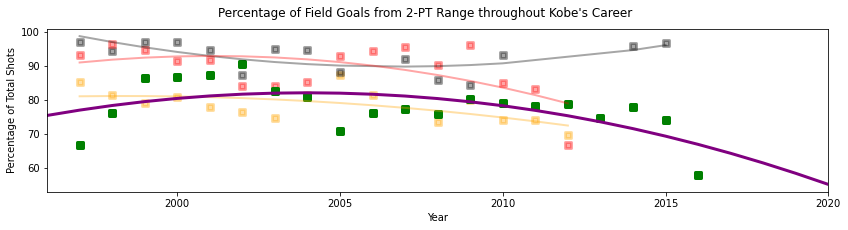

In [38]:
#Perform quadratic regression on FG%
x = two_DF.index
y = two_DF['% of Total Shots that were 2-PT FG']
z = np.polyfit(x, y, 2)
coeffs = []
for i in range (0, len(z)):
    coeffs.append(z[i])
    
#Create figure
fig = matplotlib.pyplot.figure()
fig.suptitle("Percentage of Field Goals from 2-PT Range throughout Kobe's Career")
matplotlib.pyplot.xlabel('Year')
matplotlib.pyplot.ylabel('Percentage of Total Shots')
plt.xlim(1996, 2020)
fig.set_figheight(3)
fig.set_figwidth(14)
    
#Plot actual values and curve of best fit
X = seasons['year']
Y = fg_regression(X)

a = lebron_data['Season']
b = lebron_data['2R']
c = np.polyfit(a, b, 2)
coeffs = []
for i in range (0, len(c)):
    coeffs.append(c[i])
A = lebron_data['Season']
B = fg_regression(A)
matplotlib.pyplot.scatter(lebron_data['Season'], lebron_data['2R'], color='orange', marker="s", linewidths = 3, alpha=0.35)
matplotlib.pyplot.plot(A, B, color='orange', linewidth=2, alpha=0.35)

a = mj_data['Season']
b = mj_data['2R']
c = np.polyfit(a, b, 2)
coeffs = []
for i in range (0, len(c)):
    coeffs.append(c[i])
A = mj_data['Season']
B = fg_regression(A)
matplotlib.pyplot.scatter(mj_data['Season'], mj_data['2R'], color='black', marker="s", linewidths = 3, alpha=0.35)
matplotlib.pyplot.plot(A, B, color='black', linewidth=2, alpha=0.35)

a = wade_data['Season']
b = wade_data['2R']
c = np.polyfit(a, b, 2)
coeffs = []
for i in range (0, len(c)):
    coeffs.append(c[i])
A = wade_data['Season']
B = fg_regression(A)
matplotlib.pyplot.scatter(wade_data['Season'], wade_data['2R'], color='red', marker="s", linewidths = 3, alpha=0.35)
matplotlib.pyplot.plot(A, B, color='red', linewidth=2, alpha=0.35)
    
matplotlib.pyplot.scatter(two_DF.index, two_DF['% of Total Shots that were 2-PT FG'], color='green', marker="s", linewidths = 3)
matplotlib.pyplot.plot(X, Y, color='purple', linewidth=3)

#Print predictions
for a in range (2017, 2021):
    print("Prediction for", a, ":", round(fg_regression(a), 1), "%")

Prediction for 2017 : 35.6 %
Prediction for 2018 : 38.5 %
Prediction for 2019 : 41.5 %
Prediction for 2020 : 44.8 %


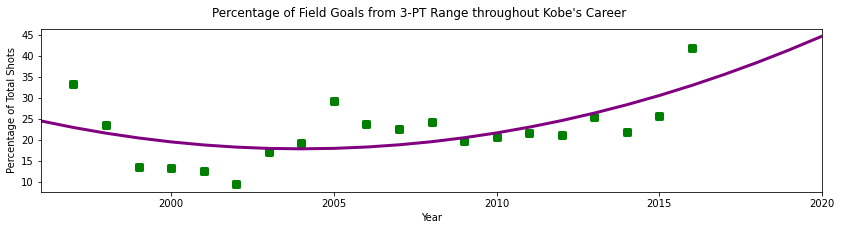

In [39]:
#Perform quadratic regression on FG%
x = two_DF.index
y = two_DF['% of Total Shots that were 3-PT FG']
z = np.polyfit(x, y, 2)
coeffs = []
for i in range (0, len(z)):
    coeffs.append(z[i])
    
#Create figure
fig = matplotlib.pyplot.figure()
fig.suptitle("Percentage of Field Goals from 3-PT Range throughout Kobe's Career")
matplotlib.pyplot.xlabel('Year')
matplotlib.pyplot.ylabel('Percentage of Total Shots')
plt.xlim(1996, 2020)
fig.set_figheight(3)
fig.set_figwidth(14)
 
#Plot actual values and curve of best fit
X = seasons['year']
Y = fg_regression(X)
    
matplotlib.pyplot.scatter(two_DF.index, two_DF['% of Total Shots that were 3-PT FG'], color='green', marker="s", linewidths = 3)
matplotlib.pyplot.plot(X, Y, color='purple', linewidth=3)

#Print predictions
for a in range (2017, 2021):
    print("Prediction for", a, ":", round(fg_regression(a), 1), "%")

Prediction for 2017 : 35.6 %
Prediction for 2018 : 33.6 %
Prediction for 2019 : 31.5 %
Prediction for 2020 : 29.1 %


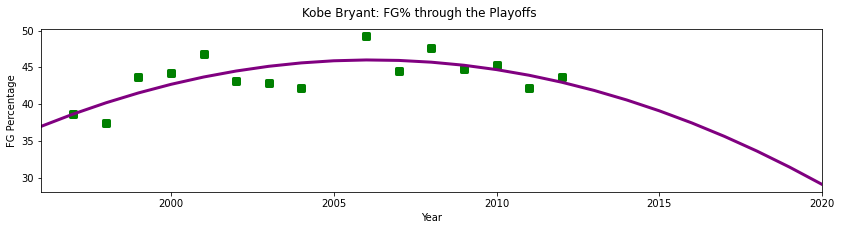

In [40]:
#Create data frame of FG percentage throughout playoffs by season
playoffs = kobe_data[ (kobe_data['playoffs'] == 1) ].pivot_table(index=['season'])
playoffs['shot_made_flag'] = 100*playoffs['shot_made_flag']

#Perform quadratic regression on FG%
x = playoffs.index
y = playoffs['shot_made_flag']
z = np.polyfit(x, y, 2)
coeffs = []
for i in range (0, len(z)):
    coeffs.append(z[i])

#Create figure
fig = matplotlib.pyplot.figure()
fig.suptitle('Kobe Bryant: FG% through the Playoffs')
matplotlib.pyplot.xlabel('Year')
matplotlib.pyplot.ylabel('FG Percentage')
plt.xlim(1996, 2020)
fig.set_figheight(3)
fig.set_figwidth(14)
    
#Plot actual values and curve of best fit
X = seasons['year']
Y = fg_regression(X)

matplotlib.pyplot.scatter(playoffs.index, playoffs['shot_made_flag'], color='green', marker="s", linewidths = 3)
matplotlib.pyplot.plot(X, Y, color='purple', linewidth=3)

#Print predictions
for a in range (2017, 2021):
    print("Prediction for", a, ":", round(fg_regression(a), 1), "%")

## Predictions for Null Values in Dataset

In the given dataset, whether or not Kobe made a field goal is stored as a binary (made shot = 1, missed shot = 0).

There are 5,000 empty values for which we are supposed to predict.

This prediction model takes into account 14 factors: action type, combined shot type, x-location, y-location, period, playoffs, season, shot distance, shot type, shot area, shot zone, game date, matchup, and opponent.

In [41]:
#Extend list of factors
appended_factors = ['loc_x', 'loc_y', 'period', 'playoffs', 'shot_distance']
for x in range (0, len(appended_factors)):
    factors.append(appended_factors[x])

In [42]:
#Create data frames of null values and known values, create list of all factors
non_data = kobe_data[ ~(kobe_data['shot_made_flag'] == 0) & ~(kobe_data['shot_made_flag'] == 1) ]
data = kobe_data[ (kobe_data['shot_made_flag'] == 0) | (kobe_data['shot_made_flag'] == 1) ]

#Establish X and Y values for known shots, create decision tree for predictions
X = data[factors]
Y = data['shot_made_flag']

p_model = tree.DecisionTreeClassifier()
p_model = p_model.fit(X, Y)

In [43]:
#Create empty lists
predictions = []
x_locations = []
y_locations = []
season = []
shot_type = []
game_id = []

#Make predictions for all 5,000 null values, append court location and prediction to above lists
for x in range (0, len(non_data)):
    inputs = []
    
    non_index = non_data.index[x]
    for y in range (0, len(factors)):
        inputs.append(non_data[ factors[y] ][non_index])
    
    prediction = p_model.predict([inputs])
    prediction = int(prediction[0])
    
    predictions.append(prediction)
    x_locations.append(non_data['loc_x'][non_index])
    y_locations.append(non_data['loc_y'][non_index])
    season.append(non_data['season'][non_index])
    shot_type.append(non_data['shot_type'][non_index])
    game_id.append(non_data['game_id'][non_index])

In [44]:
#Create data frame of all predicted shot attempts with x and y locations
DF_data = {'loc_x': x_locations, 'loc_y': y_locations, 'predictions': predictions, 'season': season, 'shot_type': shot_type, 'game_id': game_id}
generated_predictions = pd.DataFrame(data=DF_data)

## Visual Representation of Every Shot from Kobe Bryant's Career

Using the results from the prediction, all 30,697 shots that Kobe took are graphed.

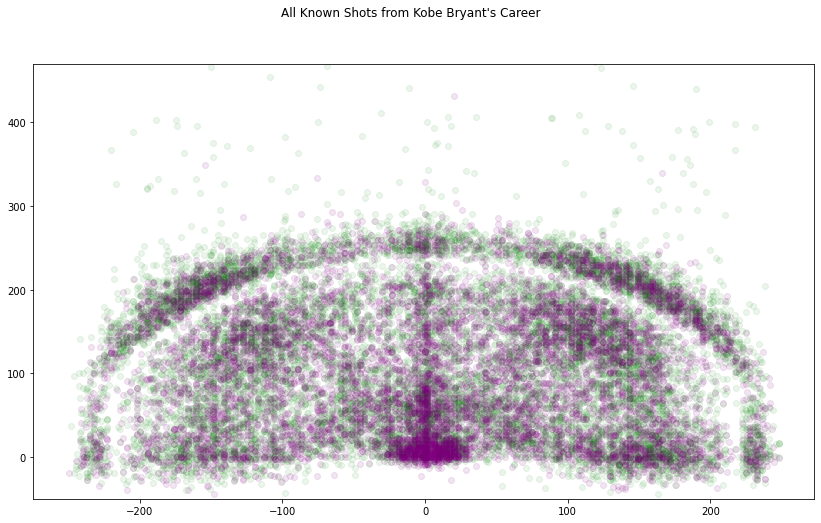

In [45]:
#Create data frames of all known misses and makes
miss = kobe_data[(kobe_data.shot_made_flag == 0)]
make = kobe_data[(kobe_data.shot_made_flag == 1)]

#Create figure
fig = matplotlib.pyplot.figure()
fig.suptitle("All Known Shots from Kobe Bryant's Career")
plt.ylim(-50, 470)

#Plot all known misses and makes in green and purple, respectively
plt.scatter(miss['loc_x'], miss['loc_y'], color='green', alpha=0.08)
plt.scatter(make['loc_x'], make['loc_y'], color='purple', alpha=0.1)

#Adjust figure dimensions
fig.set_figheight(8)
fig.set_figwidth(14)

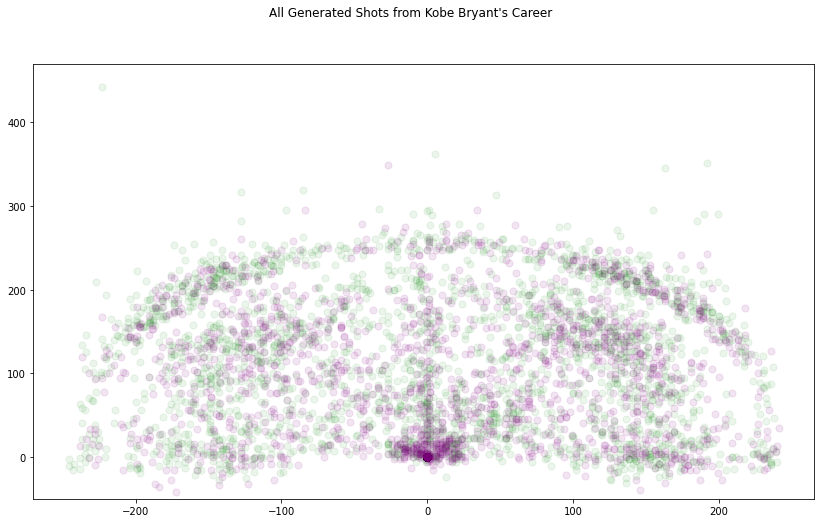

In [46]:
#Create data frames of all predicted misses and makes
gen_miss = generated_predictions[(generated_predictions['predictions'] == 0)]
gen_make = generated_predictions[(generated_predictions['predictions'] == 1)]

#Create figure
fig = matplotlib.pyplot.figure()
fig.suptitle("All Generated Shots from Kobe Bryant's Career")
plt.ylim(-50, 470)

#Plot all predicted misses and makes in green and purple, respectively
plt.scatter(gen_miss['loc_x'], gen_miss['loc_y'], color='green', alpha=0.08, s=50)
plt.scatter(gen_make['loc_x'], gen_make['loc_y'], color='purple', alpha=0.1, s=50)

#Adjust figure dimensions
fig.set_figheight(8)
fig.set_figwidth(14)

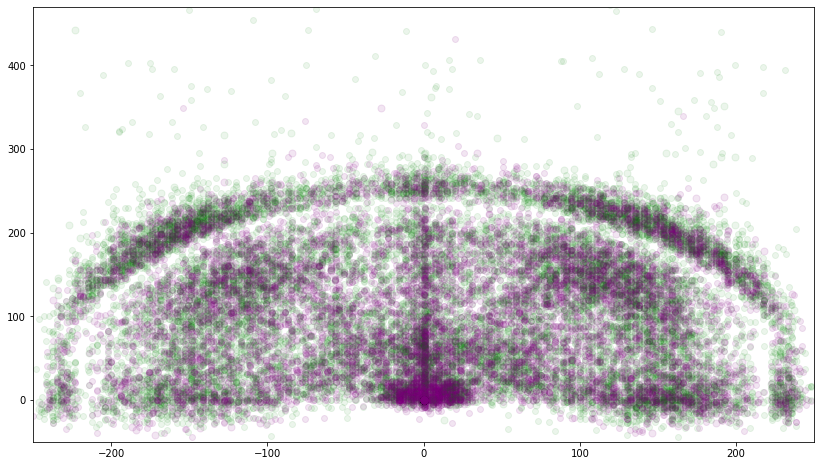

In [49]:
fig = matplotlib.pyplot.figure()
#fig.suptitle("All Total Shots from Kobe Bryant's Career")
plt.xlim(-250, 250)
plt.ylim(-50, 470)

plt.scatter(miss['loc_x'], miss['loc_y'], color='green', alpha=0.08)
plt.scatter(make['loc_x'], make['loc_y'], color='purple', alpha=0.1)
plt.scatter(gen_miss['loc_x'], gen_miss['loc_y'], color='green', alpha=0.08, s=50)
plt.scatter(gen_make['loc_x'], gen_make['loc_y'], color='purple', alpha=0.1, s=50)

fig.set_figheight(8)
fig.set_figwidth(14)

# The End